In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')


In [2]:


##########################
# 1. Load Your Excel Data
##########################

path = 'Dataset3_PortfolioReplicaStrategyErrataCorrige.xlsx'

# (A) Read the names (full names and tickers)
full_names_df = pd.read_excel(path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # skip the date column
tickers_df = pd.read_excel(path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]        # skip the date column
variable_info = dict(zip(tickers, full_names))

# (B) Read the actual data
data_raw = pd.read_excel(path, header=None, skiprows=6)
data_raw.columns = ['Date'] + tickers  # first column is Date, others are tickers
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date').sort_index()

print("Dataset preview:")
display(data.head())


Dataset preview:


,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
Date,,,,,,,,,,,,,,
2007-10-23,1633.44,414.14,350.2138,1343.63,113.70,110.515625,759.0,82.85,1525.50,4393.0,2212.00,1570.5,103.385,103.718750
2007-10-30,1663.89,423.26,352.5413,1356.53,113.79,110.656250,787.8,87.44,1536.00,4476.0,2217.75,1610.5,103.410,103.812500
2007-11-06,1651.59,419.51,354.1758,1360.20,113.79,110.875000,823.4,93.26,1525.00,4425.0,2233.50,1575.5,103.410,104.046875
2007-11-13,1601.81,405.98,357.2217,1347.16,114.35,111.718750,799.0,88.83,1483.25,4323.0,2066.75,1440.5,103.595,104.304688
2007-11-20,1570.74,398.54,359.4446,1335.21,114.72,113.156250,791.4,95.49,1446.00,4296.0,2035.50,1472.5,103.800,104.945312


In [3]:


##########################################################
# 2. Build the Target (Monster) Index Using Log Returns
##########################################################

# Weighted log returns: 50% HFRXGL, 25% MSCI World, 25% Global Agg Bond
index_components = {
    'HFRXGL Index': 0.5,
    'MXWO Index': 0.25,
    'LEGATRUU Index': 0.25
}

# Compute log returns for each component
component_returns = np.log(data[list(index_components.keys())]).diff().dropna()

# Weighted sum of log returns
weighted_returns = pd.DataFrame(index=component_returns.index)
for component, weight in index_components.items():
    weighted_returns[component] = component_returns[component] * weight

target_returns = weighted_returns.sum(axis=1)   # log returns of the target index
target_returns.name = 'Target_Index_LOGRET'


In [4]:


#############################################################
# 3. Futures Log Returns
#############################################################
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]

# Log returns for each future
futures_returns = np.log(data[futures_contracts]).diff().dropna()

# Align dates
common_dates = futures_returns.index.intersection(target_returns.index)
target_aligned = target_returns.loc[common_dates]
futures_aligned = futures_returns.loc[common_dates]

# Merge into one DataFrame
combined_data = pd.concat([target_aligned, futures_aligned], axis=1).dropna()
# We rename the target column to "Target_Index" to match the function's expectation
# But keep in mind these are STILL LOG RETURNS, not prices
combined_data.columns = ["Target_Index"] + futures_contracts

print("\nCombined data (log returns) preview:")
display(combined_data.head())



Combined data (log returns) preview:


,Target_Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
Date,,,,,,,,,,,
2007-10-30,0.011051,0.000791,0.001272,0.037242,0.053921,0.006859,0.018717,0.002596,0.025151,0.000242,0.000903
2007-11-06,0.000652,0.000000,0.001975,0.044198,0.064438,-0.007187,-0.011460,0.007077,-0.021972,0.000000,0.002255
2007-11-13,-0.010327,0.004909,0.007581,-0.030081,-0.048667,-0.027759,-0.023321,-0.077593,-0.089582,0.001787,0.002475
2007-11-20,-0.007801,0.003230,0.012785,-0.009557,0.072297,-0.025435,-0.006265,-0.015236,0.021971,0.001977,0.006123
2007-11-27,-0.003624,0.003133,0.007018,0.028157,-0.031597,-0.013577,-0.012885,-0.001475,0.008453,0.001204,0.001488


# (A) Lag Order Selection
The function select_order is used to choose a lag order (k_ar_diff) for the VECM, based on criteria such as the AIC (Akaike Information Criterion).

If the selection fails, a default lag order of 1 is used.

# (B) Cointegration Rank Estimation
Using the rolling window of level data, the Johansen cointegration test is applied through select_coint_rank:


# (C) Fitting the VECM Model
When cointegration is detected (i.e., r >= 1), the code fits a VECM using the chosen lag order and cointegration rank:


# (D) Extracting the Cointegration Vector and Constructing Weights
Once the VECM has been fitted successfully, the cointegrating vector (beta) is extracted:

<br>
If the target beta is nearly zero, the replication weight estimation is considered unreliable, and the code falls back to the last set of weights.

Otherwise, the cointegrating vector is normalized so that the weight corresponding to the target index becomes -1. The replication weights for the futures are then set using the normalized vector and the target column is excluded from these weights.
<br>

# (E) Enforcing Gross Exposure Constraint
The absolute sum of the replication weights (gross exposure) is computed:


# (F) Calculating Transaction Costs
When updating weights, transaction costs are incurred based on the difference (turnover) from the previous period:


# (G) VaR Scaling (Risk Adjustment)
If there is a sufficient history of replication returns (at least 12 returns), historical returns are gathered (up to the previous 52 observations).

The VaR of these historical returns is computed using the calculate_var function.

If the computed VaR exceeds a threshold (max_var_threshold), the replication weights are further scaled down to limit risk exposure.

The scaling factor used in this adjustment is stored for later analysis.

# (H) Calculating Replication Return for the Next Period
The code computes the replication return for the next period by taking a dot product of the futures returns and the latest replication weights and then subtracting any transaction costs.

The result is stored along with the corresponding date from the original data.

Gross exposures are also recorded for each step.

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank
from scipy import stats
import warnings

warnings.filterwarnings('ignore')


def calculate_var(returns, confidence=0.01, horizon=4):
    """
    Calculate VaR using a simple Gaussian model.
    """
    sigma = np.std(returns)
    z_score = stats.norm.ppf(confidence)
    var_value = -z_score * sigma * np.sqrt(horizon)
    return var_value


def run_vecm(
    df,
    target_col="Target_Index",
    rolling_window=100,
    rebalancing_window=4,
    transaction_cost_rate=0.001,
    maxlags_for_order=1,
    deterministic="co",
    var_confidence=0.95,
    var_horizon=1,
    max_var_threshold=0.05,
    max_gross_exposure=2.0,
    short_term_weight=0.5  # Tuning parameter for the dynamic adjustment
):
    """
    Improved VECM replication strategy with dynamic error correction adjustment.
    
    Steps:
      1. Preprocess data: drop missing values and convert log returns to levels.
      2. For each rolling window:
         a. Select lag order via AIC.
         b. Determine cointegration rank using Johansen’s method.
         c. Fit VECM if cointegration exists.
         d. Extract the cointegrating vector (beta) and adjustment coefficients (alpha).
         e. Compute static replication weights by normalizing the cointegrating vector
            (target weight fixed at -1).
         f. Compute the error correction term from the last observation in the window.
         g. Use the alpha coefficients to adjust static weights:
              dynamic_adjustment = short_term_weight * ((futures_alpha / target_alpha) - 1) * error_correction
         h. Combine static weights with the dynamic adjustment.
         i. Enforce gross exposure constraints and compute transaction costs.
         j. Optionally, apply VaR scaling.
         k. Calculate the replication return for the next period.
    Returns:
      A dictionary containing time series of replication returns, target returns,
      cumulative returns, weights history, and various performance metrics.
    """
    
    # Drop missing data and convert log returns to levels (for cointegration analysis)
    df = df.dropna()
    df_levels = np.exp(df.cumsum())
    df_returns = df.copy()  # Keep original log returns for PnL calculations

    # Identify target column and futures columns
    all_cols = df.columns.tolist()
    if target_col not in all_cols:
        raise ValueError(f"Target column '{target_col}' not found in df.")
    futures_cols = [c for c in all_cols if c != target_col]

    # Prepare storage lists
    weights_history = []
    replica_returns = []
    target_dates = []
    var_values = []
    scaling_factors = []
    transaction_costs = []
    gross_exposures = []

    n_obs = len(df_levels)

    # Loop over rolling windows
    for i in range(n_obs - rolling_window - 1):
        if i % rebalancing_window == 0:
            # (a) Extract the current window data (in levels)
            window_data_levels = df_levels.iloc[i: i + rolling_window]

            # (b) Select lag order using AIC (with at least 1 lag)
            try:
                order_res = select_order(window_data_levels, maxlags=maxlags_for_order, deterministic='ci')
                k_ar_diff = max(1, int(order_res.selected_orders['aic']))
                k_ar_diff = min(k_ar_diff, rolling_window - 1)
            except Exception as e:
                k_ar_diff = 1

            # (c) Determine cointegration rank using Johansen's method
            try:
                rank_res = select_coint_rank(window_data_levels, det_order=0, k_ar_diff=k_ar_diff)
                r = rank_res.rank
                if r < 1:
                    # No cointegration, fallback to previous weights or zeros if not available
                    replication_weights = weights_history[-1].copy() if weights_history else np.zeros(len(futures_cols))
                else:
                    # (d) Fit the VECM
                    try:
                        vecm_model = VECM(window_data_levels, 
                                          k_ar_diff=k_ar_diff, 
                                          coint_rank=r, 
                                          deterministic=deterministic)
                        vecm_res = vecm_model.fit()
                    except Exception as e:
                        replication_weights = weights_history[-1].copy() if weights_history else np.zeros(len(futures_cols))
                    else:
                        # (e) Extract the cointegrating vector (beta) and adjustment coefficients (alpha)
                        beta = vecm_res.beta[:, 0]    # cointegration vector
                        alpha = vecm_res.alpha[:, 0]  # adjustment (loading) coefficients

                        col_list = window_data_levels.columns.tolist()
                        target_idx = col_list.index(target_col)
                        target_beta = beta[target_idx]
                        if abs(target_beta) < 1e-12:
                            replication_weights = weights_history[-1].copy() if weights_history else np.zeros(len(futures_cols))
                        else:
                            # (f) Compute static weights by normalizing the cointegration vector (target fixed at -1)
                            norm_beta = beta / target_beta
                            norm_beta *= -1.0
                            static_weights = np.array([norm_beta[idx] for idx, col in enumerate(col_list) if col != target_col])
                            
                            # (g) Compute dynamic adjustment using the alpha coefficients
                            target_alpha = alpha[target_idx]
                            futures_alpha = np.array([alpha[idx] for idx, col in enumerate(col_list) if col != target_col])
                            
                            # Compute error correction term from the last observation in the window
                            current_y = window_data_levels.iloc[-1].values
                            futures_values = np.array([current_y[col_list.index(f)] for f in futures_cols])
                            error_correction = current_y[target_idx] + np.dot(static_weights, futures_values)
                            
                            # If target_alpha is nearly zero, skip the dynamic adjustment
                            if abs(target_alpha) < 1e-12:
                                dynamic_adjustment = 0.0
                            else:
                                dynamic_adjustment = short_term_weight * ((futures_alpha / target_alpha) - 1.0) * error_correction
                            
                            # (h) Combine the static weights with the dynamic adjustment
                            replication_weights = static_weights + dynamic_adjustment
            except Exception as e:
                replication_weights = weights_history[-1].copy() if weights_history else np.zeros(len(futures_cols))

            # (i) Enforce the gross exposure constraint
            gross_exp = np.sum(np.abs(replication_weights))
            if gross_exp > max_gross_exposure and gross_exp > 1e-12:
                replication_weights *= (max_gross_exposure / gross_exp)
            weights_history.append(replication_weights)

            # (j) Compute transaction costs based on turnover
            if len(weights_history) > 1:
                prev_w = weights_history[-2]
                turnover = np.sum(np.abs(replication_weights - prev_w))
                cost = transaction_cost_rate * turnover
            else:
                cost = 0.0
            transaction_costs.append(cost)

            # (k) Apply VaR scaling if enough replication returns are available
            scaling_factor = 1.0
            if len(replica_returns) >= 12:
                hist_ret = []
                for j in range(max(0, len(replica_returns) - 52), len(replica_returns)):
                    idx_map = i + rolling_window - (len(replica_returns) - j)
                    if idx_map < len(df_returns):
                        fut_ret = df_returns.iloc[idx_map][futures_cols].values
                        w_ret = np.dot(fut_ret, replication_weights)
                        hist_ret.append(w_ret)
                var_val = calculate_var(hist_ret, confidence=var_confidence, horizon=var_horizon)
                if var_val > max_var_threshold and var_val > 1e-12:
                    scaling_factor = max_var_threshold / var_val
                    replication_weights *= scaling_factor
                var_values.append(var_val)
            else:
                var_values.append(np.nan)
            scaling_factors.append(scaling_factor)

            # (l) Calculate the replication return for the next period
            next_idx = i + rolling_window
            if next_idx < len(df_returns):
                next_fut_ret = df_returns.iloc[next_idx][futures_cols].values
                rep_ret = np.dot(next_fut_ret, replication_weights) - cost
                replica_returns.append(rep_ret)
                target_dates.append(df_returns.index[next_idx])
            gross_exposures.append(np.sum(np.abs(replication_weights)))

    # Build time-series and performance metrics
    replica_series = pd.Series(replica_returns, index=target_dates)
    target_series = df_returns[target_col].reindex(replica_series.index)
    cum_target = np.exp(target_series.cumsum())  # Convert cumulative log returns to levels
    cum_replica = (1 + replica_series).cumprod()

    freq = 52  # for example, weekly data
    rep_mean_ret = replica_series.mean() * freq
    tgt_mean_ret = target_series.mean() * freq
    rep_vol = replica_series.std() * np.sqrt(freq)
    tgt_vol = target_series.std() * np.sqrt(freq)
    rep_sharpe = rep_mean_ret / rep_vol if rep_vol > 1e-12 else 0.0
    tgt_sharpe = tgt_mean_ret / tgt_vol if tgt_vol > 1e-12 else 0.0

    te = (replica_series - target_series).std() * np.sqrt(freq)
    info_ratio = (rep_mean_ret - tgt_mean_ret) / te if te > 1e-12 else 0.0
    dd = 1 - cum_replica.div(cum_replica.cummax())
    corr = replica_series.corr(target_series)
    avg_gross = np.mean(gross_exposures) if gross_exposures else 0.0
    avg_var = np.nanmean(var_values)

    results = {
        "replication_returns": replica_series,
        "target_returns": target_series,
        "cumulative_target": cum_target,
        "cumulative_replication": cum_replica,
        "weights_history": weights_history,
        "gross_exposures": gross_exposures,
        "var_values": var_values,
        "scaling_factors": scaling_factors,
        "transaction_costs": transaction_costs,
        "replica_mean_return": rep_mean_ret,
        "target_mean_return": tgt_mean_ret,
        "replica_vol": rep_vol,
        "target_vol": tgt_vol,
        "replica_sharpe": rep_sharpe,
        "target_sharpe": tgt_sharpe,
        "tracking_error": te,
        "information_ratio": info_ratio,
        "max_drawdown": dd.max() if len(dd) else 0.0,
        "correlation": corr,
        "avg_gross_exposure": avg_gross,
        "avg_var": avg_var
    }

    return results


In [6]:
import optuna

# Function to run Optuna optimization
def run_optuna( n_trials=50 ):
    db_path = f"sqlite:///optuna_VECM.db"
    study = optuna.create_study(
        direction="minimize",
        study_name="study_VECM",
        storage=db_path,
        load_if_exists=True,
    )

    print(f"Starting optimization ... ")
    study.optimize(objective, n_trials=n_trials)
    print("Optimization complete")

    return study



def objective(trial):
    # Suggest hyperparameters for the VECM replication strategy.
    maxlags_for_order = trial.suggest_int("maxlags_for_order", 1, 5)
    max_gross_exposure = trial.suggest_float("max_gross_exposure", 1.0, 3.0)
    short_term_weight = trial.suggest_float("short_term_weight", 0.0, 1.0)
    
    # Run the VECM replication routine with these hyperparameters.
    # The run_vecm_replication_dynamic function should return a dictionary that contains a key 'information_ratio'
    # representing the performance metric you want to optimize.
    result = run_vecm(
        df = combined_data,                             # your DataFrame with log returns (must include 'Target_Index')
        target_col="Target_Index",      # the column for the target index
        rolling_window=156,
        rebalancing_window=1,
        transaction_cost_rate=0.001,      # fixed transaction cost rate
        maxlags_for_order=maxlags_for_order,
        deterministic="co",
        var_confidence=0.95,
        var_horizon=1,
        max_var_threshold=0.05,
        max_gross_exposure=max_gross_exposure,
        short_term_weight=short_term_weight,
    )
    
    # Retrieve the information ratio.
    # Here we assume higher information ratio is better.
    info_ratio = result['information_ratio']
    
    # Report the intermediate result (negative info_ratio since we minimize) and implement pruning.
    trial.report(-info_ratio, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Because Optuna minimizes by default, we return the negative info_ratio.
    return -info_ratio



In [7]:
study = run_optuna(50)

# Display the best hyperparameters and corresponding information ratio
print("Best hyperparameters found:")
print(study.best_trial.params)
print("Best (maximized) information ratio:", -study.best_trial.value)

[I 2025-04-14 11:04:31,872] Using an existing study with name 'study_VECM' instead of creating a new one.


Starting optimization ... 


[I 2025-04-14 11:04:40,929] Trial 3 finished with value: 0.33984817917943566 and parameters: {'maxlags_for_order': 2, 'max_gross_exposure': 1.4948345184648457, 'short_term_weight': 0.7818909883184096}. Best is trial 3 with value: 0.33984817917943566.
[I 2025-04-14 11:04:49,295] Trial 4 finished with value: 0.25470854172388485 and parameters: {'maxlags_for_order': 1, 'max_gross_exposure': 2.7027543817876625, 'short_term_weight': 0.3926001682547514}. Best is trial 4 with value: 0.25470854172388485.
[I 2025-04-14 11:04:58,980] Trial 5 finished with value: 0.2010097779236248 and parameters: {'maxlags_for_order': 3, 'max_gross_exposure': 1.411045851188199, 'short_term_weight': 0.7835476687721338}. Best is trial 5 with value: 0.2010097779236248.
[I 2025-04-14 11:05:07,654] Trial 6 finished with value: 0.2886327107979634 and parameters: {'maxlags_for_order': 2, 'max_gross_exposure': 2.059069115989604, 'short_term_weight': 0.5429237012009915}. Best is trial 5 with value: 0.2010097779236248.
[I

Optimization complete
Best hyperparameters found:
{'maxlags_for_order': 3, 'max_gross_exposure': 2.6641611078929297, 'short_term_weight': 0.119045346363018}
Best (maximized) information ratio: -0.0896245872816068


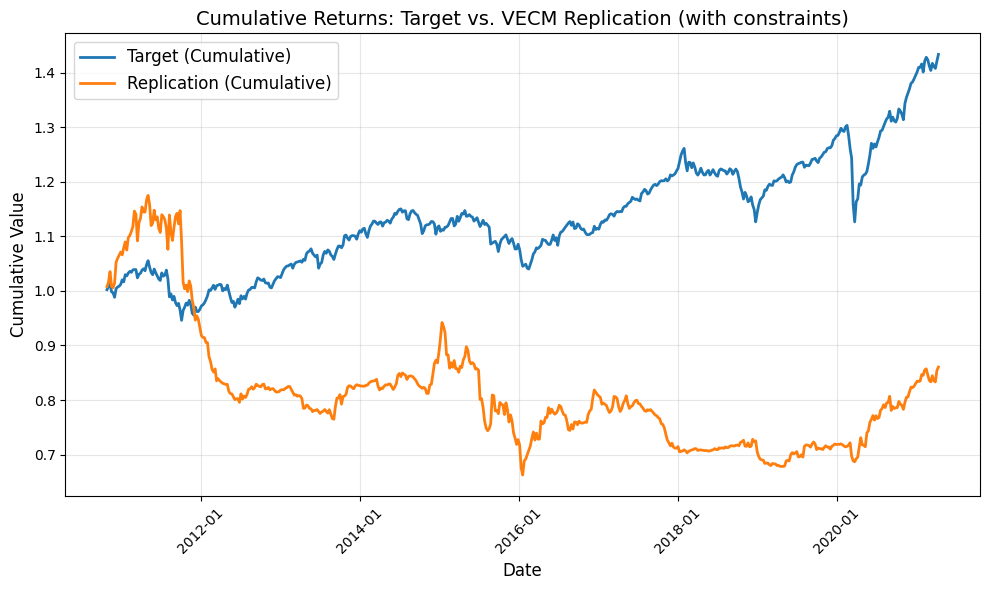

=== Performance Summary ===
Replica Ann. Return:  -0.98%
Target Ann. Return:   3.42%
Replica Volatility:   9.53%
Target Volatility:    5.60%
Replica Sharpe:       -0.10
Target Sharpe:        0.61
Tracking Error:       10.27%
Information Ratio:    -0.43
Correlation:          0.16
Max Drawdown (rep):   43.60%
Avg Gross Exposure:   1.00
Avg VaR:              -3.77%


In [10]:

# Run the replication
results = run_vecm(
    df=combined_data,
    target_col="Target_Index",
    rolling_window=156,
    rebalancing_window=1,
    transaction_cost_rate=0.0005,
    maxlags_for_order=1,
    deterministic="c0",
    var_confidence=0.95,
    var_horizon=4,
    max_var_threshold=0.05,
    max_gross_exposure=1.0
)

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(results['cumulative_target'], label='Target (Cumulative)', linewidth=2)
plt.plot(results['cumulative_replication'], label='Replication (Cumulative)', linewidth=2)
plt.title("Cumulative Returns: Target vs. VECM Replication (with constraints)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Value", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary
print("=== Performance Summary ===")
print(f"Replica Ann. Return:  {results['replica_mean_return']:.2%}")
print(f"Target Ann. Return:   {results['target_mean_return']:.2%}")
print(f"Replica Volatility:   {results['replica_vol']:.2%}")
print(f"Target Volatility:    {results['target_vol']:.2%}")
print(f"Replica Sharpe:       {results['replica_sharpe']:.2f}")
print(f"Target Sharpe:        {results['target_sharpe']:.2f}")
print(f"Tracking Error:       {results['tracking_error']:.2%}")
print(f"Information Ratio:    {results['information_ratio']:.2f}")
print(f"Correlation:          {results['correlation']:.2f}")
print(f"Max Drawdown (rep):   {results['max_drawdown']:.2%}")
print(f"Avg Gross Exposure:   {results['avg_gross_exposure']:.2f}")
print(f"Avg VaR:              {results['avg_var']:.2%}")
